In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/208.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/473.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/333.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/45.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/369.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/56.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/89.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/20.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/275.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/212.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/239.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/58.jpg
/kaggle/input/cityscapes-image-pa

In [3]:
# !wget --quiet https://github.com/sizhky/torch_snippets.git
!pip install torch_snippets
from torch_snippets import *

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
# from torch_snippets import *
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchinfo import summary
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models, datasets
from xml.etree import ElementTree as et
import torchvision
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **0. Создаем 2 списка: путей каритнок и путей аннотаций**

In [5]:
# mask_files = glob.glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
im_ma_train = Glob('/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/*')
im_ma_val = Glob('/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/*')

image_mask_train = [str(i) for i in im_ma_train]#.sort()
image_mask_val = [str(i) for i in im_ma_val]#.sort()

image_mask_train.sort()
image_mask_val.sort()

print(image_mask_train[:2])
print(image_mask_val[:2])
print(len(image_mask_train))
print(len(image_mask_val))

['/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1.jpg', '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/10.jpg']
['/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/1.jpg', '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/10.jpg']
2975
500


In [6]:
image_mask_train[:5]

['/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1.jpg',
 '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/10.jpg',
 '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/100.jpg',
 '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1000.jpg',
 '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1001.jpg']

In [7]:
image_mask_val[:5]

['/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/1.jpg',
 '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/10.jpg',
 '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/100.jpg',
 '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/101.jpg',
 '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/102.jpg']

# **1. Смотрим картинки**

Each image file is 256x512

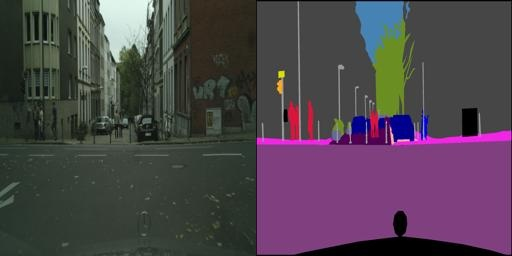

In [8]:
img_open = Image.open('/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/10.jpg')
img = cv2.imread("/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/10.jpg")
crop_img_left = img[0+2:256-2, 0+2:256-2] # img[y:y+h, x:x+w]
crop_img_right = img[0+2:256-2, 256+2:512-2] # img[y:y+h, x:x+w]
img_open

(252, 252, 3)


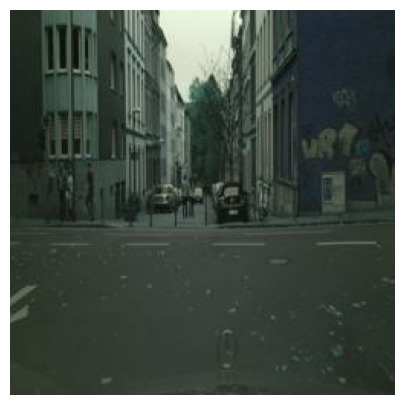

In [9]:
print(crop_img_left.shape)
show(crop_img_left)

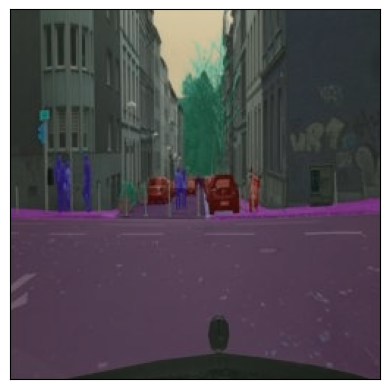

In [10]:
plt.imshow(crop_img_left)
plt.imshow(crop_img_right,alpha=0.4)
plt.xticks([]), plt.yticks([])
plt.show()

(252, 252, 3)


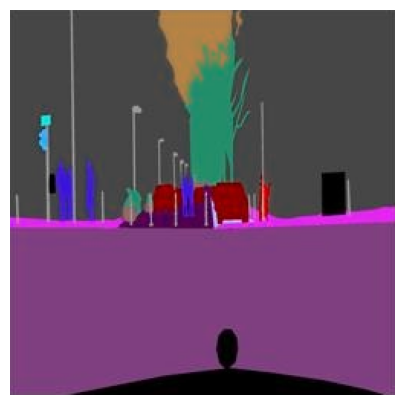

In [11]:
print(crop_img_right.shape)
show(crop_img_right)

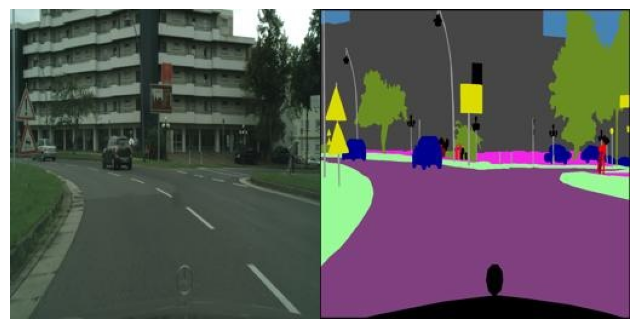

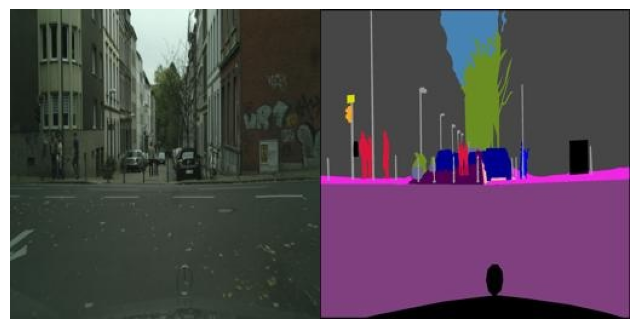

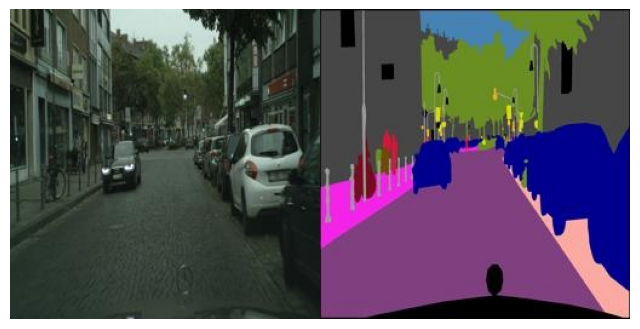

In [11]:
for i in image_mask_train[:3]:
    show(i,sz=8)

# **3. Смотрим аннотации (изображения)**

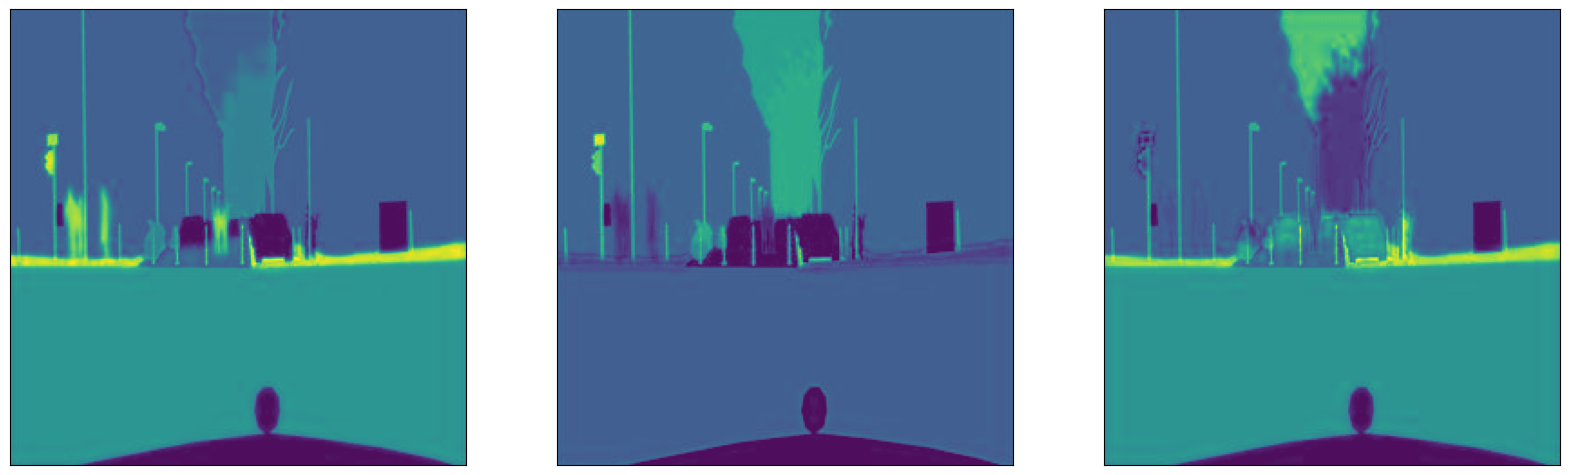

In [12]:
rows,cols=1,3
fig=plt.figure(figsize=(20,20))
for i in np.arange(1,4):
    fig.add_subplot(rows,cols,i)
    msk=crop_img_right
    msk=cv2.cvtColor(crop_img_right,cv2.COLOR_BGR2RGB)
#     msk=cv2.imread(msk_path)
    plt.imshow(msk.transpose(-1,0,1)[i-1],alpha=0.95)
    plt.xticks([]), plt.yticks([])
plt.show()

In [13]:
crop_img_right.transpose(-1,0,1)

array([[[ 74,  73,  77, ...,  79,  76,  77],
        [ 74,  72,  74, ...,  74,  71,  73],
        [ 72,  68,  73, ...,  72,  66,  70],
        ...,
        [122, 122, 116, ..., 124, 128, 123],
        [116, 121, 110, ..., 109, 114, 114],
        [107, 115, 106, ..., 117, 125, 117]],

       [[ 74,  73,  77, ...,  79,  76,  77],
        [ 74,  72,  74, ...,  74,  71,  73],
        [ 72,  68,  73, ...,  72,  66,  70],
        ...,
        [ 71,  69,  60, ...,  66,  70,  68],
        [ 74,  77,  63, ...,  60,  65,  66],
        [ 73,  80,  68, ...,  75,  83,  75]],

       [[ 74,  73,  77, ...,  79,  76,  77],
        [ 74,  72,  74, ...,  74,  71,  73],
        [ 72,  68,  73, ...,  72,  66,  70],
        ...,
        [128, 126, 119, ..., 124, 128, 123],
        [121, 124, 112, ..., 110, 115, 114],
        [110, 120, 110, ..., 116, 124, 116]]], dtype=uint8)

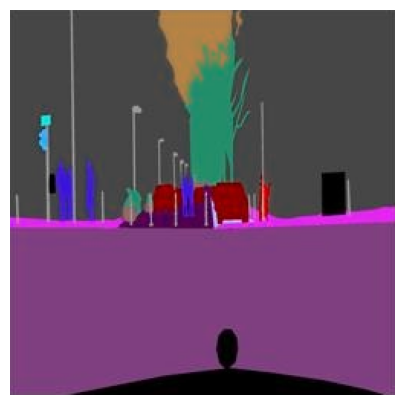

In [13]:
show(crop_img_right)

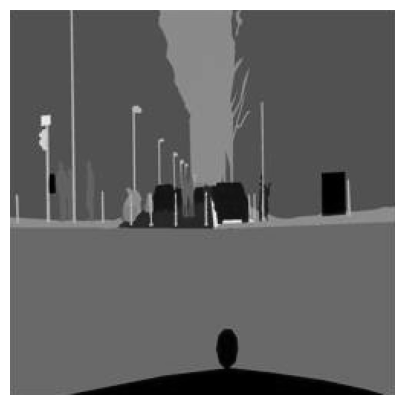

In [15]:
img=show(cv2.cvtColor(crop_img_right,cv2.COLOR_BGR2GRAY))
img

# **4. Смотрим содержимое каналов маски**

In [16]:
img = cv2.cvtColor(crop_img_right,cv2.COLOR_BGR2GRAY)
img

array([[ 74,  73,  77, ...,  79,  76,  77],
       [ 74,  72,  74, ...,  74,  71,  73],
       [ 72,  68,  73, ...,  72,  66,  70],
       ...,
       [ 94,  92,  84, ...,  90,  94,  91],
       [ 93,  96,  83, ...,  81,  86,  86],
       [ 88,  96,  85, ...,  92, 100,  92]], dtype=uint8)

In [17]:
img.shape

(252, 252)

In [18]:
# читаем картинку маски, 4меняем каналы местасми на (3,250,250),
# an = cv2.imread(mask[2], 1).transpose(2,0,1)#/255
# r,g,b = an

# lst = []
# for _ in [0,1,2]:
#     k = r,g,b
#     h = 'rgb'
#     for i in k[_]:
#         for j in i:
#             if j not in lst: lst.append(j)
#     print(f'Значения в канале {h[_]}: {lst}')

# **8. Трансформации**

In [14]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

# **9. Создаем DataLoader**

In [ ]:
img_open = Image.open('/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/10.jpg')
img = cv2.imread("/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/10.jpg")
crop_img_left = img[0+2:256-2, 0+2:256-2] # img[y:y+h, x:x+w]
crop_img_right = img[0+2:256-2, 256+2:512-2] # img[y:y+h, x:x+w]
# img_open
mask = cv2.cvtColor(crop_img_right,cv2.COLOR_BGR2GRAY)
mask = cv2.resize(mask, (224,224))
print(mask.shape)
# mask.transpose(-1,0,1)/255
show(mask)
mask.shape
print(mask.shape)
print('----------------------------')
ce_masks = torch.Tensor(mask.transpose(-1,0,1)[None]).long().to(device)
# show(ce_masks)
ce_masks.shape

In [62]:
class SegData(Dataset):
    def __init__(self, list_pics_anns):
        self.list_pics_anns = list_pics_anns
    def __len__(self):
        return len(self.list_pics_anns)
    def __getitem__(self, ix):
        img = self.list_pics_anns[ix]
        img = cv2.imread(img)
        crop_img_left_image = img[0+2:256-2, 0+2:256-2] # img[y:y+h, x:x+w]
        crop_img_right_mask = img[0+2:256-2, 256+2:512-2] # img[y:y+h, x:x+w]
        
        crop_img_right_mask = cv2.cvtColor(crop_img_right_mask,cv2.COLOR_BGR2GRAY)
#         print(crop_img_right_mask)
        image = cv2.resize(crop_img_left_image, (224,224))
        mask = cv2.resize(crop_img_right_mask, (224,224))
#         image = Image.open(img_path).convert('RGB')
#         print(self.pictures[ix])
#         image = read(self.pictures[ix],1)#[..., ::-1]
#         print(image)
#         image = cv2.resize(image, (224,224))
#         print(image.shape)
#         mask = read(self.annotations[ix])
#         mask[mask > 0] = 1
#         print(mask.shape)
#         mask = cv2.resize(mask, (224,224))
#         print(mask.shape)
        return image, mask#.transpose(-1,0,1)/255
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [63]:
trn_ds = SegData(image_mask_train)
val_ds = SegData(image_mask_val)
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

**Данные в dataset**
(224, 224, 3)
(224, 224)


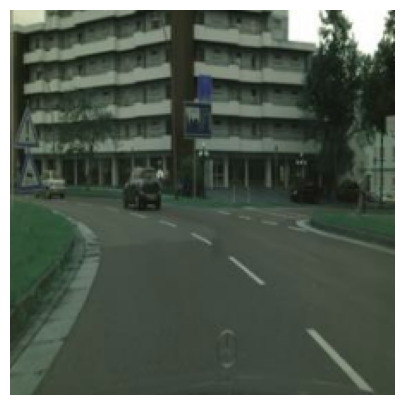

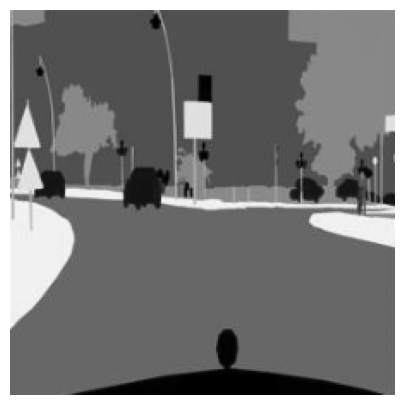

In [102]:
print('**Данные в dataset**')
for i in trn_ds:
    print(i[0].shape)
    print(i[1].shape)
    show(i[0])
    show(i[1])
    break

**Данные в dataloader**
torch.Size([4, 3, 224, 224])


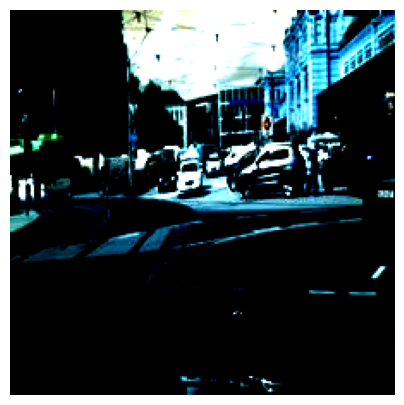

torch.Size([4, 224, 224])


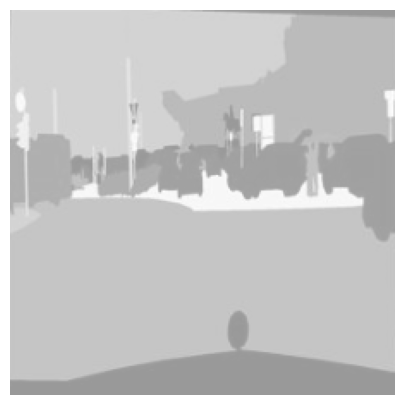

In [103]:
print('**Данные в dataloader**')
for i in trn_dl:
    print(i[0].shape)
    show(i[0][0])
    print(i[1].shape)
    show(i[1][0],alpha=0.4)
    break

# **4. Смотрим содержимое каналов маски в dl**

In [74]:
i[1][0]

tensor([[74, 74, 74,  ..., 75, 76, 77],
        [73, 72, 71,  ..., 71, 71, 72],
        [71, 68, 72,  ..., 71, 67, 70],
        ...,
        [92, 89, 88,  ..., 92, 94, 91],
        [93, 93, 87,  ..., 86, 86, 87],
        [89, 94, 88,  ..., 92, 98, 92]])

In [95]:
lst = []
for _ in trn_dl:
    for i in np.array(_[1][0]):
#         print(i.shape)
        for j in i:
#             print(j)
            if j not in lst: lst.append(j)
    break
print(f'Значения в маске, типа число классов: \n{lst}')

Значения в маске, типа число классов: 
[55, 76, 75, 71, 73, 74, 77, 124, 155, 102, 68, 66, 72, 70, 69, 64, 92, 110, 67, 61, 57, 59, 80, 95, 89, 78, 65, 39, 38, 37, 36, 35, 34, 21, 19, 18, 17, 14, 12, 11, 10, 13, 8, 7, 4, 2, 3, 1, 0, 121, 150, 97, 103, 96, 63, 106, 129, 122, 123, 120, 118, 119, 117, 108, 109, 107, 104, 101, 93, 90, 85, 82, 62, 58, 47, 30, 24, 23, 16, 15, 9, 5, 99, 98, 113, 115, 116, 126, 54, 52, 50, 48, 46, 43, 40, 31, 29, 26, 20, 6, 86, 91, 114, 51, 42, 41, 32, 27, 25, 22, 53, 148, 60, 45, 44, 147, 79, 125, 111, 94, 100, 105, 88, 145, 83, 87, 133, 33, 84, 142, 140, 141, 143, 127, 112, 139, 28, 136, 131, 163, 185, 194, 188, 181, 177, 180, 169, 158, 149, 208, 207, 198, 193, 192, 197, 200, 201, 186, 196, 134, 195, 191, 199, 49, 153, 204, 138, 184, 56, 164, 183, 175, 81, 182, 168, 170, 179, 159, 167, 178, 132, 154, 187, 190, 206, 128, 152, 165, 172, 174, 157, 171, 161, 156, 189, 202, 160, 176, 130, 173, 166, 146, 151, 144, 205, 135, 137, 162, 221, 203]


# **10. Смотрим картинку, маску и картинку с наложенной маской (в одну строку)**

In [98]:
x = iter(trn_ds)

(224, 224, 3)
(224, 224)


<function matplotlib.pyplot.show(close=None, block=None)>

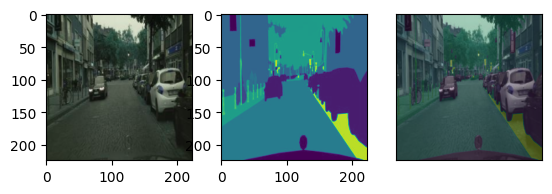

In [101]:
# входные данные должны быть размера (224, 224, 3) и (3, 224, 224)
im,m = next(x)
print(im.shape)
print(m.shape)
fig, ax = plt.subplots(1,3)
ax[0].imshow(im)
ax[1].imshow(m)
ax[2].imshow(im)
ax[2].imshow(m,alpha=0.3)
plt.xticks([]), plt.yticks([])
plt.show

# **11. Смотрим картинку**

In [27]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [28]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [29]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, weights=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(weights=weights).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [30]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    # print(preds.shape)
    # print(targets.shape)
    # print('----------------------')
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [31]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    # print(_masks.shape)
    # print(ce_masks.shape)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    # print('---------------')
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [32]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 149MB/s]  


In [33]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  val_loss: 0.005  trn_loss: 0.165  val_acc: 1.000  trn_acc: 0.993  (131.53s - 2499.02s remaining)
EPOCH: 2.000  val_loss: 0.001  trn_loss: 0.002  val_acc: 1.000  trn_acc: 1.000  (252.93s - 2276.38s remaining)
EPOCH: 3.000  val_loss: 0.001  trn_loss: 0.001  val_acc: 1.000  trn_acc: 1.000  (375.32s - 2126.81s remaining)
EPOCH: 4.000  val_loss: 0.000  trn_loss: 0.000  val_acc: 1.000  trn_acc: 1.000  (497.81s - 1991.25s remaining)
EPOCH: 5.000  val_loss: 0.000  trn_loss: 0.000  val_acc: 1.000  trn_acc: 1.000  (620.12s - 1860.35s remaining)
EPOCH: 6.000  val_loss: 0.000  trn_loss: 0.000  val_acc: 1.000  trn_acc: 1.000  (742.11s - 1731.58s remaining)
EPOCH: 7.000  val_loss: 0.000  trn_loss: 0.000  val_acc: 1.000  trn_acc: 1.000  (863.76s - 1604.13s remaining)
EPOCH: 8.000  val_loss: 0.000  trn_loss: 0.000  val_acc: 1.000  trn_acc: 1.000  (985.39s - 1478.08s remaining)
EPOCH: 9.000  val_loss: 0.000  trn_loss: 0.000  val_acc: 1.000  trn_acc: 1.000  (1107.10s - 1353.13s remaining)


100%|██████████| 121/121 [00:01<00:00, 115.15it/s]


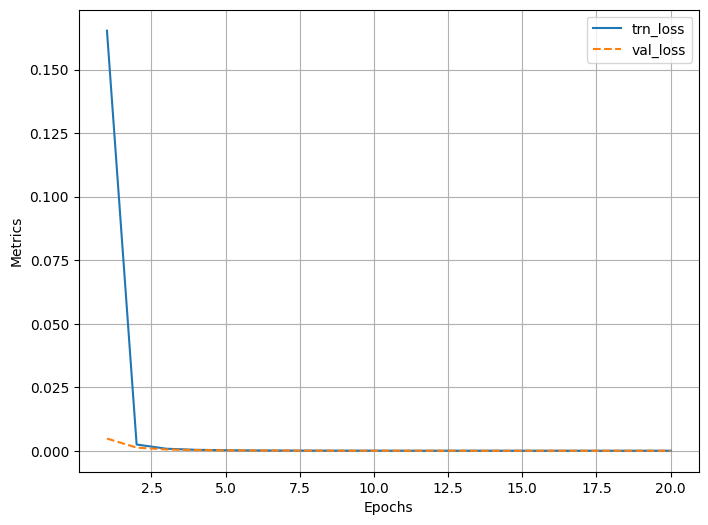

In [34]:
log.plot_epochs(['trn_loss','val_loss'])

100%|██████████| 121/121 [00:01<00:00, 115.65it/s]


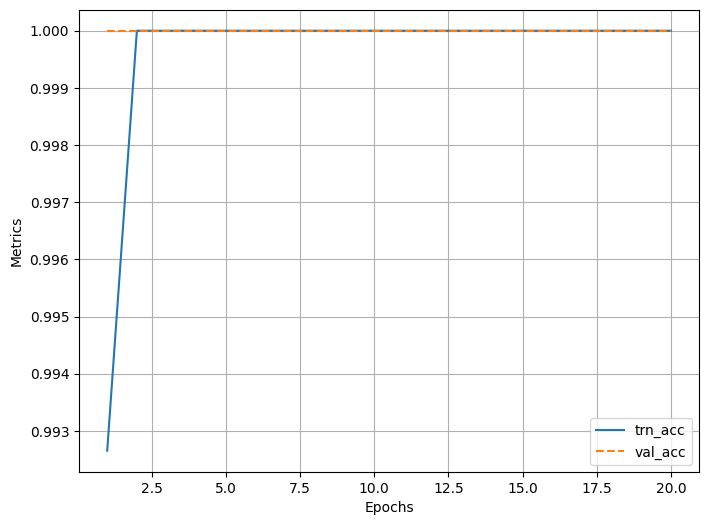

In [35]:
log.plot_epochs(['trn_acc','val_acc'])

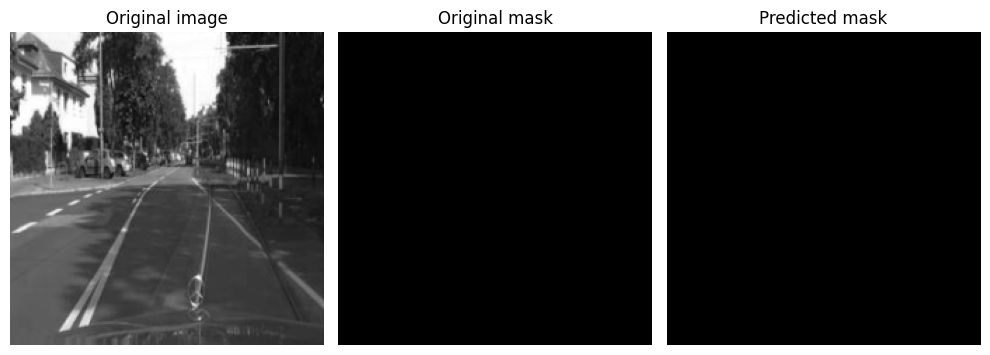

In [36]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'],sz=10)

In [37]:
save_path = 'People_on_the street_multi_semantic_segm_Unet'
torch.save(model.state_dict(), save_path)
!du -hsc {save_path} # size of the model on disk

du: cannot access 'People_on_the': No such file or directory
du: cannot access 'street_multi_semantic_segm_Unet': No such file or directory
0	total


In [38]:
# load_path = 'People_on_the street_multi_semantic_segm_Unet.pth'
# model.load_state_dict(torch.load(load_path)) #  # строка при загрузке на GРU
# # model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu'))) # строка при загрузке на СРU